<a href="https://colab.research.google.com/github/ShreyPandit/Parsimonious_Computing_LALR/blob/main/Parsimonius_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf

In [3]:
cd drive/My\ Drive/DATANPY

/content/drive/.shortcut-targets-by-id/1_2jEwr_tcvvsTgME4u6n8HiqvH1YGhsH/DATANPY


In [4]:
x_train = np.load('bgedv2_X_tr_float64.npy')
y_train = np.load('bgedv2_Y_tr_0-4760_float64.npy')
x_test = np.load('bgedv2_X_te_float64.npy')
y_test = np.load('bgedv2_Y_te_0-4760_float64.npy')
x_val = np.load('bgedv2_X_va_float64.npy')
y_val = np.load('bgedv2_Y_va_0-4760_float64.npy')

In [ ]:
print(x_train.shape)
print(y_train.shape)

(88807, 943)
(88807, 4760)


In [ ]:
print(x_test.shape)
print(y_test.shape)

(11101, 943)
(11101, 4760)


In [ ]:
print(x_val.shape)
print(y_val.shape)

(11101, 943)
(11101, 4760)


# 3 layered Relu model-LALR

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(5120, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4760,activation = 'relu'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              966656    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 5120)              5248000   
_________________________________________________________________
dropout (Dropout)            (None, 5120)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4760)              24375960  
Total params: 30,594,712
Trainable params: 30,592,664
Non-trainable params: 2,048
_________________________________________________________________


In [ ]:
from tensorflow.keras import backend as K
func_pen = K.function([model.layers[0].input], [model.layers[-2].output])
func_last = K.function([model.layers[0].input], [model.layers[-1].output])

In [ ]:
lrs = []
K1 = 0.
beta1 = 0.9
batch_size=200
from tqdm import tqdm

In [ ]:
def lr_schedule(epoch):
    global K1

    Kz = 0.
    Ka = 0.
    y_norm = 0.
    
    for i in tqdm(range((len(x_train) - 1) // batch_size + 1)):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
    	
        tmp_pen = np.array(func_pen([xb]))
        activ_pen = np.linalg.norm(tmp_pen)
        
        if activ_pen > Kz:
            Kz = activ_pen

        tmp_last = np.array(func_last([xb]))
        activ_last = np.linalg.norm(tmp_last)
        
        if activ_last > Ka:
            Ka = activ_last
        
        y_norms = np.linalg.norm(np.array(yb))
        if y_norms > y_norm:
            y_norm = y_norms


    print("The value of K_z is ",Kz, " The value of Ka is ",Ka, " Value of y is ",y_norm)
    K1 = (1/batch_size)*(Ka + y_norm)*Kz
    lr = 1 / K1
    lr = lr*0.3
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr


In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
from tensorflow.keras.optimizers import SGD
optimizer = 'adam'
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

100%|██████████| 445/445 [00:10<00:00, 42.21it/s]


The value of K_z is  303.42325  The value of Ka is  214.33691  Value of y is  1052.7268806322327
Epoch 0 LR = 0.00015606442461437985
Epoch 1/100
445/445 [==============================] - 8s 19ms/step - loss: 0.6360 - mse: 0.7491 - val_loss: 0.5975 - val_mse: 0.6808


100%|██████████| 445/445 [00:07<00:00, 58.53it/s]

The value of K_z is  362.35773  The value of Ka is  604.2255  Value of y is  1052.7268806322327
Epoch 1 LR = 9.993179530042122e-05
Epoch 2/100
  1/445 [..............................] - ETA: 0s - loss: 0.6219 - mse: 0.7708

445/445 [==============================] - 8s 18ms/step - loss: 0.5938 - mse: 0.6627 - val_loss: 0.5818 - val_mse: 0.6500


100%|██████████| 445/445 [00:07<00:00, 58.37it/s]


The value of K_z is  333.32672  The value of Ka is  629.8015  Value of y is  1052.7268806322327
Epoch 2 LR = 0.00010698397200120858
Epoch 3/100
445/445 [==============================] - 8s 18ms/step - loss: 0.5824 - mse: 0.6398 - val_loss: 0.5733 - val_mse: 0.6326


100%|██████████| 445/445 [00:07<00:00, 58.76it/s]

The value of K_z is  317.5613  The value of Ka is  648.70966  Value of y is  1052.7268806322327
Epoch 3 LR = 0.00011104727639380468
Epoch 4/100
  1/445 [..............................] - ETA: 0s - loss: 0.5910 - mse: 0.6947

445/445 [==============================] - 8s 18ms/step - loss: 0.5739 - mse: 0.6232 - val_loss: 0.5666 - val_mse: 0.6191


100%|██████████| 445/445 [00:07<00:00, 59.79it/s]

The value of K_z is  306.7667  The value of Ka is  667.5639  Value of y is  1052.7268806322327
Epoch 4 LR = 0.00011369495203629074
Epoch 5/100
  4/445 [..............................] - ETA: 7s - loss: 0.5633 - mse: 0.5941

445/445 [==============================] - 8s 18ms/step - loss: 0.5675 - mse: 0.6100 - val_loss: 0.5614 - val_mse: 0.6083


100%|██████████| 445/445 [00:07<00:00, 59.40it/s]

The value of K_z is  296.48236  The value of Ka is  665.9836  Value of y is  1052.7268806322327
Epoch 5 LR = 0.00011774695085166382
Epoch 6/100
  4/445 [..............................] - ETA: 6s - loss: 0.5650 - mse: 0.6095

445/445 [==============================] - 8s 18ms/step - loss: 0.5626 - mse: 0.6003 - val_loss: 0.5578 - val_mse: 0.6002


100%|██████████| 445/445 [00:07<00:00, 59.37it/s]

The value of K_z is  288.15045  The value of Ka is  662.5668  Value of y is  1052.7268806322327
Epoch 6 LR = 0.0001213929498991842
Epoch 7/100
  1/445 [..............................] - ETA: 0s - loss: 0.5545 - mse: 0.5702

445/445 [==============================] - 8s 18ms/step - loss: 0.5582 - mse: 0.5912 - val_loss: 0.5544 - val_mse: 0.5929


100%|██████████| 445/445 [00:07<00:00, 60.06it/s]


The value of K_z is  283.31125  The value of Ka is  675.48737  Value of y is  1052.7268806322327
Epoch 7 LR = 0.00012254337893486555
Epoch 8/100
445/445 [==============================] - 8s 18ms/step - loss: 0.5548 - mse: 0.5842 - val_loss: 0.5518 - val_mse: 0.5869


100%|██████████| 445/445 [00:07<00:00, 59.61it/s]

The value of K_z is  278.0511  The value of Ka is  687.074  Value of y is  1052.7268806322327
Epoch 8 LR = 0.0001240301057705413
Epoch 9/100
  1/445 [..............................] - ETA: 0s - loss: 0.5551 - mse: 0.5891

445/445 [==============================] - 8s 18ms/step - loss: 0.5518 - mse: 0.5779 - val_loss: 0.5495 - val_mse: 0.5814


100%|██████████| 445/445 [00:07<00:00, 59.16it/s]

The value of K_z is  275.67795  The value of Ka is  694.47205  Value of y is  1052.7268806322327
Epoch 9 LR = 0.0001245681081448461
Epoch 10/100
  4/445 [..............................] - ETA: 6s - loss: 0.5535 - mse: 0.5816

445/445 [==============================] - 8s 18ms/step - loss: 0.5493 - mse: 0.5723 - val_loss: 0.5475 - val_mse: 0.5773


100%|██████████| 445/445 [00:07<00:00, 59.94it/s]

The value of K_z is  271.84354  The value of Ka is  703.1498  Value of y is  1052.7268806322327
Epoch 10 LR = 0.00012570085534727952
Epoch 11/100
  1/445 [..............................] - ETA: 0s - loss: 0.5493 - mse: 0.5610

445/445 [==============================] - 8s 19ms/step - loss: 0.5470 - mse: 0.5679 - val_loss: 0.5458 - val_mse: 0.5741


100%|██████████| 445/445 [00:07<00:00, 59.02it/s]

The value of K_z is  270.67603  The value of Ka is  701.1274  Value of y is  1052.7268806322327
Epoch 11 LR = 0.0001263886157960504
Epoch 12/100
  1/445 [..............................] - ETA: 0s - loss: 0.5393 - mse: 0.5500

445/445 [==============================] - 8s 19ms/step - loss: 0.5454 - mse: 0.5650 - val_loss: 0.5445 - val_mse: 0.5714


100%|██████████| 445/445 [00:07<00:00, 58.18it/s]

The value of K_z is  266.52997  The value of Ka is  690.65424  Value of y is  1052.7268806322327
Epoch 12 LR = 0.0001291257524287936
Epoch 13/100
  1/445 [..............................] - ETA: 0s - loss: 0.5518 - mse: 0.5912

445/445 [==============================] - 8s 19ms/step - loss: 0.5439 - mse: 0.5622 - val_loss: 0.5437 - val_mse: 0.5698


100%|██████████| 445/445 [00:07<00:00, 60.01it/s]

The value of K_z is  265.824  The value of Ka is  708.7122  Value of y is  1052.7268806322327
Epoch 13 LR = 0.00012814138708827587
Epoch 14/100
  4/445 [..............................] - ETA: 7s - loss: 0.5570 - mse: 0.5924

445/445 [==============================] - 8s 19ms/step - loss: 0.5426 - mse: 0.5600 - val_loss: 0.5426 - val_mse: 0.5681


100%|██████████| 445/445 [00:07<00:00, 58.13it/s]

The value of K_z is  263.4349  The value of Ka is  700.8378  Value of y is  1052.7268806322327
Epoch 14 LR = 0.00012988414312865485
Epoch 15/100
  4/445 [..............................] - ETA: 7s - loss: 0.5402 - mse: 0.5488

445/445 [==============================] - 8s 19ms/step - loss: 0.5414 - mse: 0.5575 - val_loss: 0.5416 - val_mse: 0.5657


100%|██████████| 445/445 [00:07<00:00, 56.72it/s]


The value of K_z is  262.31476  The value of Ka is  702.5485  Value of y is  1052.7268806322327
Epoch 15 LR = 0.00013031165417432312
Epoch 16/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5403 - mse: 0.5552 - val_loss: 0.5414 - val_mse: 0.5646


100%|██████████| 445/445 [00:07<00:00, 58.59it/s]

The value of K_z is  261.9824  The value of Ka is  718.65497  Value of y is  1052.7268806322327
Epoch 16 LR = 0.00012929060215810677
Epoch 17/100
  1/445 [..............................] - ETA: 0s - loss: 0.5365 - mse: 0.5502

445/445 [==============================] - 8s 19ms/step - loss: 0.5390 - mse: 0.5529 - val_loss: 0.5398 - val_mse: 0.5623


100%|██████████| 445/445 [00:07<00:00, 59.71it/s]


The value of K_z is  260.663  The value of Ka is  718.43225  Value of y is  1052.7268806322327
Epoch 17 LR = 0.00012996137209900918
Epoch 18/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5380 - mse: 0.5508 - val_loss: 0.5397 - val_mse: 0.5609


100%|██████████| 445/445 [00:07<00:00, 57.90it/s]


The value of K_z is  257.92535  The value of Ka is  691.9485  Value of y is  1052.7268806322327
Epoch 18 LR = 0.00013333451507857892
Epoch 19/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5372 - mse: 0.5491 - val_loss: 0.5385 - val_mse: 0.5595


100%|██████████| 445/445 [00:07<00:00, 58.25it/s]


The value of K_z is  257.9734  The value of Ka is  711.98846  Value of y is  1052.7268806322327
Epoch 19 LR = 0.00013179583313840707
Epoch 20/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5363 - mse: 0.5475 - val_loss: 0.5379 - val_mse: 0.5583


100%|██████████| 445/445 [00:07<00:00, 58.83it/s]

The value of K_z is  257.29654  The value of Ka is  709.1867  Value of y is  1052.7268806322327
Epoch 20 LR = 0.0001323526681394769
Epoch 21/100
  1/445 [..............................] - ETA: 0s - loss: 0.5316 - mse: 0.5386

445/445 [==============================] - 8s 19ms/step - loss: 0.5356 - mse: 0.5460 - val_loss: 0.5375 - val_mse: 0.5576


100%|██████████| 445/445 [00:07<00:00, 59.27it/s]


The value of K_z is  255.85652  The value of Ka is  713.5216  Value of y is  1052.7268806322327
Epoch 21 LR = 0.00013277091743941908
Epoch 22/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5351 - mse: 0.5449 - val_loss: 0.5374 - val_mse: 0.5565


100%|██████████| 445/445 [00:07<00:00, 56.94it/s]


The value of K_z is  256.19855  The value of Ka is  715.636  Value of y is  1052.7268806322327
Epoch 22 LR = 0.0001324351295239907
Epoch 23/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5344 - mse: 0.5435 - val_loss: 0.5369 - val_mse: 0.5555


100%|██████████| 445/445 [00:07<00:00, 59.04it/s]

The value of K_z is  253.90863  The value of Ka is  711.982  Value of y is  1052.7268806322327
Epoch 23 LR = 0.00013390620983241662
Epoch 24/100
  1/445 [..............................] - ETA: 0s - loss: 0.5368 - mse: 0.5415

445/445 [==============================] - 8s 19ms/step - loss: 0.5339 - mse: 0.5425 - val_loss: 0.5363 - val_mse: 0.5545


100%|██████████| 445/445 [00:07<00:00, 58.94it/s]


The value of K_z is  255.11096  The value of Ka is  717.06525  Value of y is  1052.7268806322327
Epoch 24 LR = 0.0001328923163131343
Epoch 25/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5333 - mse: 0.5414 - val_loss: 0.5361 - val_mse: 0.5542


100%|██████████| 445/445 [00:07<00:00, 58.32it/s]


The value of K_z is  253.00848  The value of Ka is  717.4181  Value of y is  1052.7268806322327
Epoch 25 LR = 0.00013396993001325787
Epoch 26/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5328 - mse: 0.5402 - val_loss: 0.5356 - val_mse: 0.5532


100%|██████████| 445/445 [00:07<00:00, 57.09it/s]

The value of K_z is  254.27051  The value of Ka is  719.43555  Value of y is  1052.7268806322327
Epoch 26 LR = 0.00013315323903006712
Epoch 27/100
  1/445 [..............................] - ETA: 0s - loss: 0.5277 - mse: 0.5143

445/445 [==============================] - 8s 19ms/step - loss: 0.5322 - mse: 0.5391 - val_loss: 0.5354 - val_mse: 0.5525


100%|██████████| 445/445 [00:07<00:00, 58.14it/s]


The value of K_z is  254.0845  The value of Ka is  742.08777  Value of y is  1052.7268806322327
Epoch 27 LR = 0.00013156896762339242
Epoch 28/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5318 - mse: 0.5380 - val_loss: 0.5349 - val_mse: 0.5515


100%|██████████| 445/445 [00:07<00:00, 56.46it/s]


The value of K_z is  252.59795  The value of Ka is  729.44867  Value of y is  1052.7268806322327
Epoch 28 LR = 0.00013328183215065094
Epoch 29/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5314 - mse: 0.5373 - val_loss: 0.5346 - val_mse: 0.5512


100%|██████████| 445/445 [00:07<00:00, 58.19it/s]

The value of K_z is  251.65102  The value of Ka is  725.572  Value of y is  1052.7268806322327
Epoch 29 LR = 0.0001340749987186585
Epoch 30/100
  4/445 [..............................] - ETA: 7s - loss: 0.5311 - mse: 0.5365

445/445 [==============================] - 8s 19ms/step - loss: 0.5309 - mse: 0.5365 - val_loss: 0.5347 - val_mse: 0.5507


100%|██████████| 445/445 [00:07<00:00, 56.64it/s]


The value of K_z is  249.70747  The value of Ka is  715.7589  Value of y is  1052.7268806322327
Epoch 30 LR = 0.00013586829777998923
Epoch 31/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5307 - mse: 0.5360 - val_loss: 0.5342 - val_mse: 0.5505


100%|██████████| 445/445 [00:07<00:00, 58.56it/s]


The value of K_z is  248.53238  The value of Ka is  717.8165  Value of y is  1052.7268806322327
Epoch 31 LR = 0.000136352057032098
Epoch 32/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5304 - mse: 0.5354 - val_loss: 0.5341 - val_mse: 0.5500


100%|██████████| 445/445 [00:07<00:00, 59.35it/s]

The value of K_z is  248.2188  The value of Ka is  727.04486  Value of y is  1052.7268806322327
Epoch 32 LR = 0.0001358164201460795
Epoch 33/100
  1/445 [..............................] - ETA: 0s - loss: 0.5338 - mse: 0.5529

445/445 [==============================] - 8s 19ms/step - loss: 0.5300 - mse: 0.5347 - val_loss: 0.5338 - val_mse: 0.5495


100%|██████████| 445/445 [00:07<00:00, 58.79it/s]

The value of K_z is  247.67618  The value of Ka is  721.9669  Value of y is  1052.7268806322327
Epoch 33 LR = 0.0001365034353140468
Epoch 34/100
  4/445 [..............................] - ETA: 6s - loss: 0.5296 - mse: 0.5193

445/445 [==============================] - 8s 19ms/step - loss: 0.5299 - mse: 0.5342 - val_loss: 0.5337 - val_mse: 0.5492


100%|██████████| 445/445 [00:07<00:00, 58.28it/s]


The value of K_z is  247.7818  The value of Ka is  731.7279  Value of y is  1052.7268806322327
Epoch 34 LR = 0.00013569889139621386
Epoch 35/100
445/445 [==============================] - 9s 19ms/step - loss: 0.5294 - mse: 0.5334 - val_loss: 0.5339 - val_mse: 0.5489


100%|██████████| 445/445 [00:07<00:00, 57.14it/s]


The value of K_z is  247.3514  The value of Ka is  726.3576  Value of y is  1052.7268806322327
Epoch 35 LR = 0.00013634534479203077
Epoch 36/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5291 - mse: 0.5328 - val_loss: 0.5332 - val_mse: 0.5485


100%|██████████| 445/445 [00:07<00:00, 58.32it/s]

The value of K_z is  245.69441  The value of Ka is  726.4463  Value of y is  1052.7268806322327
Epoch 36 LR = 0.00013725802645124044
Epoch 37/100
  1/445 [..............................] - ETA: 0s - loss: 0.5207 - mse: 0.5155

445/445 [==============================] - 8s 19ms/step - loss: 0.5289 - mse: 0.5324 - val_loss: 0.5336 - val_mse: 0.5488


100%|██████████| 445/445 [00:07<00:00, 59.45it/s]

The value of K_z is  245.67368  The value of Ka is  731.5297  Value of y is  1052.7268806322327
Epoch 37 LR = 0.0001368785241602406
Epoch 38/100
  1/445 [..............................] - ETA: 0s - loss: 0.5362 - mse: 0.5428

445/445 [==============================] - 8s 19ms/step - loss: 0.5286 - mse: 0.5318 - val_loss: 0.5334 - val_mse: 0.5485


100%|██████████| 445/445 [00:07<00:00, 59.72it/s]

The value of K_z is  244.38876  The value of Ka is  723.75775  Value of y is  1052.7268806322327
Epoch 38 LR = 0.00013820016501181446
Epoch 39/100
  1/445 [..............................] - ETA: 0s - loss: 0.5304 - mse: 0.5257

445/445 [==============================] - 8s 19ms/step - loss: 0.5285 - mse: 0.5314 - val_loss: 0.5329 - val_mse: 0.5476


100%|██████████| 445/445 [00:07<00:00, 57.97it/s]


The value of K_z is  243.31439  The value of Ka is  720.5969  Value of y is  1052.7268806322327
Epoch 39 LR = 0.0001390578172714439
Epoch 40/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5282 - mse: 0.5309 - val_loss: 0.5329 - val_mse: 0.5476


100%|██████████| 445/445 [00:07<00:00, 59.54it/s]

The value of K_z is  243.3498  The value of Ka is  727.2277  Value of y is  1052.7268806322327
Epoch 40 LR = 0.00013851963683131244
Epoch 41/100
  1/445 [..............................] - ETA: 0s - loss: 0.5347 - mse: 0.5490

445/445 [==============================] - 8s 19ms/step - loss: 0.5280 - mse: 0.5304 - val_loss: 0.5327 - val_mse: 0.5473


100%|██████████| 445/445 [00:07<00:00, 59.14it/s]

The value of K_z is  242.01671  The value of Ka is  731.40265  Value of y is  1052.7268806322327
Epoch 41 LR = 0.00013895670875103082
Epoch 42/100
  1/445 [..............................] - ETA: 0s - loss: 0.5279 - mse: 0.5401

445/445 [==============================] - 8s 19ms/step - loss: 0.5278 - mse: 0.5300 - val_loss: 0.5331 - val_mse: 0.5473


100%|██████████| 445/445 [00:07<00:00, 58.40it/s]

The value of K_z is  241.66708  The value of Ka is  731.9492  Value of y is  1052.7268806322327
Epoch 42 LR = 0.00013911512216462443
Epoch 43/100
  1/445 [..............................] - ETA: 0s - loss: 0.5362 - mse: 0.5770

445/445 [==============================] - 8s 19ms/step - loss: 0.5276 - mse: 0.5297 - val_loss: 0.5329 - val_mse: 0.5471


100%|██████████| 445/445 [00:07<00:00, 58.65it/s]

The value of K_z is  239.42574  The value of Ka is  725.12646  Value of y is  1052.7268806322327
Epoch 43 LR = 0.00014095629857289904
Epoch 44/100
  1/445 [..............................] - ETA: 0s - loss: 0.5248 - mse: 0.5350

445/445 [==============================] - 8s 19ms/step - loss: 0.5273 - mse: 0.5291 - val_loss: 0.5325 - val_mse: 0.5464


100%|██████████| 445/445 [00:07<00:00, 58.84it/s]

The value of K_z is  240.37932  The value of Ka is  732.51886  Value of y is  1052.7268806322327
Epoch 44 LR = 0.00013981576579517595
Epoch 45/100
  1/445 [..............................] - ETA: 0s - loss: 0.5255 - mse: 0.5271

445/445 [==============================] - 8s 19ms/step - loss: 0.5271 - mse: 0.5287 - val_loss: 0.5323 - val_mse: 0.5461


100%|██████████| 445/445 [00:07<00:00, 59.80it/s]


The value of K_z is  239.5505  The value of Ka is  724.1239  Value of y is  1052.7268806322327
Epoch 45 LR = 0.00014096237197381873
Epoch 46/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5270 - mse: 0.5283 - val_loss: 0.5326 - val_mse: 0.5464


100%|██████████| 445/445 [00:07<00:00, 60.08it/s]

The value of K_z is  238.43309  The value of Ka is  731.1321  Value of y is  1052.7268806322327
Epoch 46 LR = 0.00014106660310457815
Epoch 47/100
  1/445 [..............................] - ETA: 0s - loss: 0.5349 - mse: 0.5350

445/445 [==============================] - 8s 19ms/step - loss: 0.5268 - mse: 0.5280 - val_loss: 0.5333 - val_mse: 0.5468


100%|██████████| 445/445 [00:07<00:00, 59.13it/s]

The value of K_z is  237.19366  The value of Ka is  732.1237  Value of y is  1052.7268806322327
Epoch 47 LR = 0.00014172494471459678
Epoch 48/100
  1/445 [..............................] - ETA: 0s - loss: 0.5183 - mse: 0.5058

445/445 [==============================] - 8s 19ms/step - loss: 0.5268 - mse: 0.5278 - val_loss: 0.5320 - val_mse: 0.5457


100%|██████████| 445/445 [00:07<00:00, 58.74it/s]


The value of K_z is  236.5389  The value of Ka is  729.56116  Value of y is  1052.7268806322327
Epoch 48 LR = 0.00014232159265811125
Epoch 49/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5265 - mse: 0.5274 - val_loss: 0.5324 - val_mse: 0.5460


100%|██████████| 445/445 [00:07<00:00, 59.10it/s]

The value of K_z is  235.52472  The value of Ka is  727.9906  Value of y is  1052.7268806322327
Epoch 49 LR = 0.00014306049831206284
Epoch 50/100
  1/445 [..............................] - ETA: 0s - loss: 0.5197 - mse: 0.5074

445/445 [==============================] - 8s 19ms/step - loss: 0.5263 - mse: 0.5269 - val_loss: 0.5320 - val_mse: 0.5455


100%|██████████| 445/445 [00:07<00:00, 59.30it/s]


The value of K_z is  235.2363  The value of Ka is  720.83325  Value of y is  1052.7268806322327
Epoch 50 LR = 0.0001438139441589178
Epoch 51/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5263 - mse: 0.5268 - val_loss: 0.5322 - val_mse: 0.5460


100%|██████████| 445/445 [00:07<00:00, 59.17it/s]


The value of K_z is  235.24854  The value of Ka is  745.00165  Value of y is  1052.7268806322327
Epoch 51 LR = 0.00014187315022339388
Epoch 52/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5260 - mse: 0.5263 - val_loss: 0.5319 - val_mse: 0.5451


100%|██████████| 445/445 [00:07<00:00, 59.56it/s]

The value of K_z is  234.05312  The value of Ka is  726.8372  Value of y is  1052.7268806322327
Epoch 52 LR = 0.00014405329196677015
Epoch 53/100
  1/445 [..............................] - ETA: 0s - loss: 0.5192 - mse: 0.4991

445/445 [==============================] - 8s 19ms/step - loss: 0.5258 - mse: 0.5258 - val_loss: 0.5322 - val_mse: 0.5454


100%|██████████| 445/445 [00:07<00:00, 58.37it/s]

The value of K_z is  233.93935  The value of Ka is  740.3272  Value of y is  1052.7268806322327
Epoch 53 LR = 0.00014303904024275238
Epoch 54/100
  1/445 [..............................] - ETA: 0s - loss: 0.5235 - mse: 0.5021

445/445 [==============================] - 8s 19ms/step - loss: 0.5257 - mse: 0.5256 - val_loss: 0.5319 - val_mse: 0.5453


100%|██████████| 445/445 [00:07<00:00, 57.65it/s]

The value of K_z is  233.43665  The value of Ka is  742.87445  Value of y is  1052.7268806322327
Epoch 54 LR = 0.00014314371949698376
Epoch 55/100
  1/445 [..............................] - ETA: 0s - loss: 0.5090 - mse: 0.4724

445/445 [==============================] - 8s 19ms/step - loss: 0.5256 - mse: 0.5253 - val_loss: 0.5318 - val_mse: 0.5449


100%|██████████| 445/445 [00:07<00:00, 58.74it/s]

The value of K_z is  232.16982  The value of Ka is  733.50854  Value of y is  1052.7268806322327
Epoch 55 LR = 0.00014467943252852996
Epoch 56/100
  1/445 [..............................] - ETA: 0s - loss: 0.5131 - mse: 0.5054

445/445 [==============================] - 8s 19ms/step - loss: 0.5254 - mse: 0.5249 - val_loss: 0.5314 - val_mse: 0.5444


100%|██████████| 445/445 [00:07<00:00, 59.08it/s]

The value of K_z is  231.09308  The value of Ka is  730.95685  Value of y is  1052.7268806322327
Epoch 56 LR = 0.00014556147962645845
Epoch 57/100
  1/445 [..............................] - ETA: 0s - loss: 0.5301 - mse: 0.5382

445/445 [==============================] - 8s 19ms/step - loss: 0.5253 - mse: 0.5247 - val_loss: 0.5326 - val_mse: 0.5454


100%|██████████| 445/445 [00:07<00:00, 59.33it/s]

The value of K_z is  230.00269  The value of Ka is  742.54803  Value of y is  1052.7268806322327
Epoch 57 LR = 0.00014530728248962426
Epoch 58/100
  1/445 [..............................] - ETA: 0s - loss: 0.5239 - mse: 0.5138

445/445 [==============================] - 8s 19ms/step - loss: 0.5252 - mse: 0.5244 - val_loss: 0.5315 - val_mse: 0.5444


100%|██████████| 445/445 [00:07<00:00, 59.74it/s]

The value of K_z is  229.1071  The value of Ka is  724.19183  Value of y is  1052.7268806322327
Epoch 58 LR = 0.00014738223502794973
Epoch 59/100
  1/445 [..............................] - ETA: 0s - loss: 0.5379 - mse: 0.5731

445/445 [==============================] - 8s 19ms/step - loss: 0.5251 - mse: 0.5242 - val_loss: 0.5317 - val_mse: 0.5444


100%|██████████| 445/445 [00:07<00:00, 60.05it/s]


The value of K_z is  229.12988  The value of Ka is  741.604  Value of y is  1052.7268806322327
Epoch 59 LR = 0.00014593752780745495
Epoch 60/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5249 - mse: 0.5238 - val_loss: 0.5317 - val_mse: 0.5445


100%|██████████| 445/445 [00:07<00:00, 58.77it/s]

The value of K_z is  228.89238  The value of Ka is  750.92804  Value of y is  1052.7268806322327
Epoch 60 LR = 0.00014533374512094323
Epoch 61/100
  1/445 [..............................] - ETA: 0s - loss: 0.5238 - mse: 0.5099

445/445 [==============================] - 8s 19ms/step - loss: 0.5248 - mse: 0.5236 - val_loss: 0.5313 - val_mse: 0.5439


100%|██████████| 445/445 [00:07<00:00, 58.27it/s]

The value of K_z is  226.62386  The value of Ka is  723.9325  Value of y is  1052.7268806322327
Epoch 61 LR = 0.0001490189346618002
Epoch 62/100
  4/445 [..............................] - ETA: 7s - loss: 0.5257 - mse: 0.5250

445/445 [==============================] - 8s 19ms/step - loss: 0.5247 - mse: 0.5235 - val_loss: 0.5314 - val_mse: 0.5442


100%|██████████| 445/445 [00:07<00:00, 58.95it/s]


The value of K_z is  227.33223  The value of Ka is  736.78864  Value of y is  1052.7268806322327
Epoch 62 LR = 0.00014748734941279958
Epoch 63/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5246 - mse: 0.5231 - val_loss: 0.5315 - val_mse: 0.5441


100%|██████████| 445/445 [00:07<00:00, 58.79it/s]

The value of K_z is  224.3742  The value of Ka is  717.65094  Value of y is  1052.7268806322327
Epoch 63 LR = 0.00015104708909455434
Epoch 64/100
  4/445 [..............................] - ETA: 6s - loss: 0.5208 - mse: 0.5091

445/445 [==============================] - 8s 19ms/step - loss: 0.5247 - mse: 0.5232 - val_loss: 0.5313 - val_mse: 0.5439


100%|██████████| 445/445 [00:07<00:00, 60.41it/s]


The value of K_z is  226.44649  The value of Ka is  740.2872  Value of y is  1052.7268806322327
Epoch 64 LR = 0.0001477753406044822
Epoch 65/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5243 - mse: 0.5226 - val_loss: 0.5310 - val_mse: 0.5435


100%|██████████| 445/445 [00:07<00:00, 58.96it/s]

The value of K_z is  224.42056  The value of Ka is  730.5598  Value of y is  1052.7268806322327
Epoch 65 LR = 0.00014992271347495994
Epoch 66/100
  1/445 [..............................] - ETA: 0s - loss: 0.5053 - mse: 0.4685

445/445 [==============================] - 8s 19ms/step - loss: 0.5243 - mse: 0.5225 - val_loss: 0.5312 - val_mse: 0.5437


100%|██████████| 445/445 [00:07<00:00, 58.11it/s]

The value of K_z is  223.33957  The value of Ka is  727.52344  Value of y is  1052.7268806322327
Epoch 66 LR = 0.00015090530395897838
Epoch 67/100
  4/445 [..............................] - ETA: 7s - loss: 0.5288 - mse: 0.5373

445/445 [==============================] - 8s 19ms/step - loss: 0.5242 - mse: 0.5223 - val_loss: 0.5310 - val_mse: 0.5434


100%|██████████| 445/445 [00:07<00:00, 58.98it/s]


The value of K_z is  223.73189  The value of Ka is  734.8776  Value of y is  1052.7268806322327
Epoch 67 LR = 0.00015002095394919305
Epoch 68/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5241 - mse: 0.5220 - val_loss: 0.5310 - val_mse: 0.5434


100%|██████████| 445/445 [00:07<00:00, 57.68it/s]


The value of K_z is  224.17746  The value of Ka is  742.5902  Value of y is  1052.7268806322327
Epoch 68 LR = 0.00014907957348700708
Epoch 69/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5239 - mse: 0.5217 - val_loss: 0.5311 - val_mse: 0.5434


100%|██████████| 445/445 [00:07<00:00, 59.53it/s]

The value of K_z is  223.30298  The value of Ka is  739.6111  Value of y is  1052.7268806322327
Epoch 69 LR = 0.0001499121492297998
Epoch 70/100
  1/445 [..............................] - ETA: 0s - loss: 0.5283 - mse: 0.5318

445/445 [==============================] - 8s 19ms/step - loss: 0.5239 - mse: 0.5216 - val_loss: 0.5312 - val_mse: 0.5435


100%|██████████| 445/445 [00:07<00:00, 57.84it/s]

The value of K_z is  219.91711  The value of Ka is  716.8658  Value of y is  1052.7268806322327
Epoch 70 LR = 0.00015417675936058711
Epoch 71/100
  4/445 [..............................] - ETA: 7s - loss: 0.5211 - mse: 0.5130

445/445 [==============================] - 8s 19ms/step - loss: 0.5239 - mse: 0.5214 - val_loss: 0.5311 - val_mse: 0.5434


100%|██████████| 445/445 [00:07<00:00, 59.26it/s]


The value of K_z is  219.80577  The value of Ka is  731.0175  Value of y is  1052.7268806322327
Epoch 71 LR = 0.00015303104287072157
Epoch 72/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5238 - mse: 0.5213 - val_loss: 0.5314 - val_mse: 0.5434


100%|██████████| 445/445 [00:07<00:00, 59.42it/s]

The value of K_z is  219.07707  The value of Ka is  727.4193  Value of y is  1052.7268806322327
Epoch 72 LR = 0.0001538504080999017
Epoch 73/100
  4/445 [..............................] - ETA: 6s - loss: 0.5254 - mse: 0.5264

445/445 [==============================] - 8s 19ms/step - loss: 0.5237 - mse: 0.5210 - val_loss: 0.5314 - val_mse: 0.5432


100%|██████████| 445/445 [00:07<00:00, 58.44it/s]

The value of K_z is  219.09033  The value of Ka is  731.5629  Value of y is  1052.7268806322327
Epoch 73 LR = 0.00015348383500633385
Epoch 74/100
  1/445 [..............................] - ETA: 0s - loss: 0.5227 - mse: 0.5247

445/445 [==============================] - 9s 19ms/step - loss: 0.5236 - mse: 0.5208 - val_loss: 0.5309 - val_mse: 0.5430


100%|██████████| 445/445 [00:07<00:00, 59.02it/s]

The value of K_z is  219.98657  The value of Ka is  737.9854  Value of y is  1052.7268806322327
Epoch 74 LR = 0.0001523102961465028
Epoch 75/100
  1/445 [..............................] - ETA: 0s - loss: 0.5099 - mse: 0.4806

445/445 [==============================] - 8s 19ms/step - loss: 0.5234 - mse: 0.5206 - val_loss: 0.5308 - val_mse: 0.5431


100%|██████████| 445/445 [00:07<00:00, 57.86it/s]


The value of K_z is  218.89467  The value of Ka is  736.4945  Value of y is  1052.7268806322327
Epoch 75 LR = 0.00015319760841663355
Epoch 76/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5233 - mse: 0.5203 - val_loss: 0.5309 - val_mse: 0.5431


100%|██████████| 445/445 [00:07<00:00, 59.25it/s]

The value of K_z is  217.59314  The value of Ka is  731.0466  Value of y is  1052.7268806322327
Epoch 76 LR = 0.00015458464611890627
Epoch 77/100
  4/445 [..............................] - ETA: 7s - loss: 0.5233 - mse: 0.5176

445/445 [==============================] - 8s 19ms/step - loss: 0.5233 - mse: 0.5200 - val_loss: 0.5309 - val_mse: 0.5428


100%|██████████| 445/445 [00:07<00:00, 58.62it/s]

The value of K_z is  217.42229  The value of Ka is  740.2505  Value of y is  1052.7268806322327
Epoch 77 LR = 0.0001539119649978943
Epoch 78/100
  4/445 [..............................] - ETA: 7s - loss: 0.5212 - mse: 0.5221

445/445 [==============================] - 8s 19ms/step - loss: 0.5232 - mse: 0.5198 - val_loss: 0.5306 - val_mse: 0.5422


100%|██████████| 445/445 [00:07<00:00, 58.68it/s]


The value of K_z is  215.82968  The value of Ka is  734.9342  Value of y is  1052.7268806322327
Epoch 78 LR = 0.00015550877295629468
Epoch 79/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5231 - mse: 0.5195 - val_loss: 0.5310 - val_mse: 0.5426


100%|██████████| 445/445 [00:07<00:00, 58.06it/s]

The value of K_z is  215.34886  The value of Ka is  736.61176  Value of y is  1052.7268806322327
Epoch 79 LR = 0.00015570986581210354
Epoch 80/100
  1/445 [..............................] - ETA: 0s - loss: 0.5168 - mse: 0.4904

445/445 [==============================] - 8s 19ms/step - loss: 0.5231 - mse: 0.5194 - val_loss: 0.5310 - val_mse: 0.5426


100%|██████████| 445/445 [00:07<00:00, 59.81it/s]


The value of K_z is  214.62074  The value of Ka is  735.93964  Value of y is  1052.7268806322327
Epoch 80 LR = 0.00015629683350495762
Epoch 81/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5229 - mse: 0.5192 - val_loss: 0.5312 - val_mse: 0.5424


100%|██████████| 445/445 [00:07<00:00, 57.53it/s]

The value of K_z is  214.49187  The value of Ka is  734.16644  Value of y is  1052.7268806322327
Epoch 81 LR = 0.0001565459349225537
Epoch 82/100
  1/445 [..............................] - ETA: 0s - loss: 0.5139 - mse: 0.4882

445/445 [==============================] - 8s 19ms/step - loss: 0.5228 - mse: 0.5190 - val_loss: 0.5308 - val_mse: 0.5424


100%|██████████| 445/445 [00:07<00:00, 58.26it/s]


The value of K_z is  213.98257  The value of Ka is  734.65265  Value of y is  1052.7268806322327
Epoch 82 LR = 0.00015687583929791343
Epoch 83/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5228 - mse: 0.5189 - val_loss: 0.5308 - val_mse: 0.5423


100%|██████████| 445/445 [00:07<00:00, 57.49it/s]

The value of K_z is  212.46292  The value of Ka is  733.24176  Value of y is  1052.7268806322327
Epoch 83 LR = 0.00015812271879736358
Epoch 84/100
  1/445 [..............................] - ETA: 0s - loss: 0.5155 - mse: 0.4923

445/445 [==============================] - 8s 19ms/step - loss: 0.5227 - mse: 0.5187 - val_loss: 0.5304 - val_mse: 0.5423


100%|██████████| 445/445 [00:07<00:00, 57.91it/s]

The value of K_z is  211.78918  The value of Ka is  733.8332  Value of y is  1052.7268806322327
Epoch 84 LR = 0.00015857322127158196
Epoch 85/100
  4/445 [..............................] - ETA: 7s - loss: 0.5216 - mse: 0.5075

445/445 [==============================] - 8s 19ms/step - loss: 0.5226 - mse: 0.5186 - val_loss: 0.5315 - val_mse: 0.5426


100%|██████████| 445/445 [00:07<00:00, 58.06it/s]

The value of K_z is  210.76637  The value of Ka is  732.22455  Value of y is  1052.7268806322327
Epoch 85 LR = 0.0001594863526830251
Epoch 86/100
  4/445 [..............................] - ETA: 6s - loss: 0.5384 - mse: 0.5763

445/445 [==============================] - 8s 19ms/step - loss: 0.5228 - mse: 0.5186 - val_loss: 0.5307 - val_mse: 0.5424


100%|██████████| 445/445 [00:07<00:00, 58.01it/s]

The value of K_z is  210.74493  The value of Ka is  736.64215  Value of y is  1052.7268806322327
Epoch 86 LR = 0.0001591087961644711
Epoch 87/100
  1/445 [..............................] - ETA: 0s - loss: 0.5091 - mse: 0.4909

445/445 [==============================] - 8s 19ms/step - loss: 0.5226 - mse: 0.5185 - val_loss: 0.5306 - val_mse: 0.5421


100%|██████████| 445/445 [00:07<00:00, 57.42it/s]

The value of K_z is  211.589  The value of Ka is  739.8196  Value of y is  1052.7268806322327
Epoch 87 LR = 0.00015819317193626413
Epoch 88/100
  1/445 [..............................] - ETA: 0s - loss: 0.5245 - mse: 0.5139

445/445 [==============================] - 8s 19ms/step - loss: 0.5224 - mse: 0.5182 - val_loss: 0.5304 - val_mse: 0.5420


100%|██████████| 445/445 [00:07<00:00, 59.01it/s]

The value of K_z is  210.41023  The value of Ka is  737.4883  Value of y is  1052.7268806322327
Epoch 88 LR = 0.00015928657094611056
Epoch 89/100
  1/445 [..............................] - ETA: 0s - loss: 0.5290 - mse: 0.5442

445/445 [==============================] - 8s 19ms/step - loss: 0.5223 - mse: 0.5180 - val_loss: 0.5306 - val_mse: 0.5421


100%|██████████| 445/445 [00:07<00:00, 57.32it/s]

The value of K_z is  208.38367  The value of Ka is  733.06744  Value of y is  1052.7268806322327
Epoch 89 LR = 0.0001612338171366614
Epoch 90/100
  1/445 [..............................] - ETA: 0s - loss: 0.5227 - mse: 0.5265

445/445 [==============================] - 8s 19ms/step - loss: 0.5223 - mse: 0.5180 - val_loss: 0.5308 - val_mse: 0.5425


100%|██████████| 445/445 [00:07<00:00, 57.43it/s]

The value of K_z is  209.38113  The value of Ka is  741.0021  Value of y is  1052.7268806322327
Epoch 90 LR = 0.0001597558917537051
Epoch 91/100
  1/445 [..............................] - ETA: 0s - loss: 0.5094 - mse: 0.4777

445/445 [==============================] - 8s 19ms/step - loss: 0.5223 - mse: 0.5178 - val_loss: 0.5304 - val_mse: 0.5420


100%|██████████| 445/445 [00:07<00:00, 58.56it/s]

The value of K_z is  207.49101  The value of Ka is  734.5794  Value of y is  1052.7268806322327
Epoch 91 LR = 0.0001617904851025799
Epoch 92/100
  1/445 [..............................] - ETA: 0s - loss: 0.5096 - mse: 0.4778

445/445 [==============================] - 8s 19ms/step - loss: 0.5222 - mse: 0.5177 - val_loss: 0.5308 - val_mse: 0.5423


100%|██████████| 445/445 [00:07<00:00, 59.08it/s]


The value of K_z is  207.51833  The value of Ka is  737.12524  Value of y is  1052.7268806322327
Epoch 92 LR = 0.00016153909436115248
Epoch 93/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5222 - mse: 0.5176 - val_loss: 0.5305 - val_mse: 0.5422


100%|██████████| 445/445 [00:07<00:00, 56.91it/s]


The value of K_z is  206.62596  The value of Ka is  740.155  Value of y is  1052.7268806322327
Epoch 93 LR = 0.00016196257692916693
Epoch 94/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5222 - mse: 0.5176 - val_loss: 0.5305 - val_mse: 0.5422


100%|██████████| 445/445 [00:07<00:00, 58.53it/s]

The value of K_z is  206.31496  The value of Ka is  739.751  Value of y is  1052.7268806322327
Epoch 94 LR = 0.00016224328756377334
Epoch 95/100
  1/445 [..............................] - ETA: 0s - loss: 0.5254 - mse: 0.5150

445/445 [==============================] - 8s 19ms/step - loss: 0.5221 - mse: 0.5175 - val_loss: 0.5306 - val_mse: 0.5419


100%|██████████| 445/445 [00:07<00:00, 57.87it/s]

The value of K_z is  205.59409  The value of Ka is  738.9188  Value of y is  1052.7268806322327
Epoch 95 LR = 0.00016288777862497267
Epoch 96/100
  1/445 [..............................] - ETA: 0s - loss: 0.5264 - mse: 0.5174

445/445 [==============================] - 8s 19ms/step - loss: 0.5220 - mse: 0.5173 - val_loss: 0.5307 - val_mse: 0.5422


100%|██████████| 445/445 [00:07<00:00, 58.01it/s]

The value of K_z is  203.17604  The value of Ka is  724.7673  Value of y is  1052.7268806322327
Epoch 96 LR = 0.00016613861151822145
Epoch 97/100
  1/445 [..............................] - ETA: 0s - loss: 0.5232 - mse: 0.5334

445/445 [==============================] - 8s 19ms/step - loss: 0.5221 - mse: 0.5173 - val_loss: 0.5305 - val_mse: 0.5422


100%|██████████| 445/445 [00:07<00:00, 58.35it/s]

The value of K_z is  203.83827  The value of Ka is  745.563  Value of y is  1052.7268806322327
Epoch 97 LR = 0.00016368384700877776
Epoch 98/100
  1/445 [..............................] - ETA: 0s - loss: 0.5228 - mse: 0.5186

445/445 [==============================] - 8s 19ms/step - loss: 0.5218 - mse: 0.5170 - val_loss: 0.5304 - val_mse: 0.5421


100%|██████████| 445/445 [00:07<00:00, 57.85it/s]


The value of K_z is  203.88461  The value of Ka is  742.5315  Value of y is  1052.7268806322327
Epoch 98 LR = 0.0001639229789225824
Epoch 99/100
445/445 [==============================] - 8s 19ms/step - loss: 0.5218 - mse: 0.5170 - val_loss: 0.5304 - val_mse: 0.5417


100%|██████████| 445/445 [00:07<00:00, 57.89it/s]

The value of K_z is  202.67645  The value of Ka is  729.60065  Value of y is  1052.7268806322327
Epoch 99 LR = 0.00016609648477955988
Epoch 100/100
  1/445 [..............................] - ETA: 0s - loss: 0.5197 - mse: 0.5233

445/445 [==============================] - 8s 19ms/step - loss: 0.5218 - mse: 0.5169 - val_loss: 0.5312 - val_mse: 0.5423


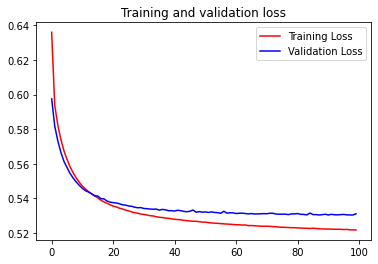

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


# 3 layered Relu Model (Paper architechture) - LALR

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000, activation='relu'))
model.add(layers.Dense(4760, activation='relu'))

In [ ]:
from tensorflow.keras import backend as K
func_pen = K.function([model.layers[0].input], [model.layers[-2].output])
func_last = K.function([model.layers[0].input], [model.layers[-1].output])

In [ ]:
lrs = []
K1 = 0.
beta1 = 0.9
batch_size=200
from tqdm import tqdm

In [ ]:
def lr_schedule(epoch):
    global K1

    Kz = 0.
    Ka = 0.
    y_norm = 0.
    
    for i in range((len(x_train) - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
    	
        tmp_pen = np.array(func_pen([xb]))
        activ_pen = np.linalg.norm(tmp_pen)
        
        if activ_pen > Kz:
            Kz = activ_pen

        tmp_last = np.array(func_last([xb]))
        activ_last = np.linalg.norm(tmp_last)
        
        if activ_last > Ka:
            Ka = activ_last
        
        y_norms = np.linalg.norm(np.array(yb))
        if y_norms > y_norm:
            y_norm = y_norms


    print("The value of K_z is ",Kz, " The value of Ka is ",Ka, " Value of y is ",y_norm)
    K1 = (1/batch_size)*(Ka + y_norm)*Kz
    lr = 1 / K1
    lr = lr*0.3
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr


In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
optimizer = 'adam'
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

The value of K_z is  307.9327  The value of Ka is  185.17705  Value of y is  1052.7268806322327
Epoch 0 LR = 0.00015740136234614006
Epoch 1/100
445/445 [==============================] - 65s 147ms/step - loss: 0.6186 - mse: 0.7231 - val_loss: 0.5891 - val_mse: 0.6701
The value of K_z is  451.33582  The value of Ka is  606.8568  Value of y is  1052.7268806322327
Epoch 1 LR = 8.010364782168967e-05
Epoch 2/100
445/445 [==============================] - 65s 147ms/step - loss: 0.5766 - mse: 0.6420 - val_loss: 0.5722 - val_mse: 0.6393
The value of K_z is  454.1984  The value of Ka is  638.80853  Value of y is  1052.7268806322327
Epoch 2 LR = 7.809523946533422e-05
Epoch 3/100
445/445 [==============================] - 65s 147ms/step - loss: 0.5658 - mse: 0.6208 - val_loss: 0.5643 - val_mse: 0.6226
The value of K_z is  445.56238  The value of Ka is  653.67926  Value of y is  1052.7268806322327
Epoch 3 LR = 7.891514011672497e-05
Epoch 4/100
445/445 [==============================] - 65s 147ms/s

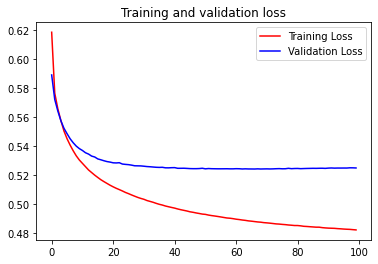

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("Relu100.csv")

# A-relu - LALR

In [ ]:
import tensorflow as tf
from keras.layers import Activation
import tensorflow.keras.backend as K
from tensorflow.keras import layers

In [ ]:
@tf.function
def ARELU(act):
  k = 0.54
  n = 1.30
  #print(act)
  x = act-act
  y = tf.where(act<=0,x,act)
  y = k * K.pow(y,n)
  t = tf.where(act<0,x,y)
  return t

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000,activation= ARELU,input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000,activation = ARELU))
model.add(layers.Dense(4760,activation = ARELU))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 9000)              8496000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 9000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 9000)              81009000  
_________________________________________________________________
dense_8 (Dense)              (None, 4760)              42844760  
Total params: 132,349,760
Trainable params: 132,349,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras import backend as K
func_pen = K.function([model.layers[0].input], [model.layers[-2].output])
func_last = K.function([model.layers[0].input], [model.layers[-1].output])

In [ ]:
lrs = []
K1 = 0.
beta1 = 0.9
batch_size=200
from tqdm import tqdm

In [ ]:
def lr_schedule(epoch):
    global K1

    Kz = 0.
    Ka = 0.
    y_norm = 0.
    
    for i in range((len(x_train) - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
    	
        tmp_pen = np.array(func_pen([xb]))
        activ_pen = np.linalg.norm(tmp_pen)
        
        if activ_pen > Kz:
            Kz = activ_pen

        tmp_last = np.array(func_last([xb]))
        activ_last = np.linalg.norm(tmp_last)
        
        if activ_last > Ka:
            Ka = activ_last
        
        y_norms = np.linalg.norm(np.array(yb))
        if y_norms > y_norm:
            y_norm = y_norms


    print("The value of K_z is ",Kz, " The value of Ka is ",Ka, " Value of y is ",y_norm)
    K1 = (1/batch_size)*(Ka + y_norm)*Kz
    lr = 1 / K1
    lr = lr*0.3
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr


In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
optimizer = 'adam'
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

The value of K_z is  59.419014  The value of Ka is  10.147014  Value of y is  1052.7268806322327
Epoch 0 LR = 0.0009500447654444336
Epoch 1/100
445/445 [==============================] - 38s 86ms/step - loss: 0.5959 - mse: 0.6514 - val_loss: 0.5808 - val_mse: 0.6217
The value of K_z is  388.55844  The value of Ka is  755.6896  Value of y is  1052.7268806322327
Epoch 1 LR = 8.538792342841863e-05
Epoch 2/100
445/445 [==============================] - 38s 85ms/step - loss: 0.5491 - mse: 0.5690 - val_loss: 0.5479 - val_mse: 0.5725
The value of K_z is  367.574  The value of Ka is  684.66473  Value of y is  1052.7268806322327
Epoch 2 LR = 9.395258611191462e-05
Epoch 3/100
445/445 [==============================] - 37s 84ms/step - loss: 0.5424 - mse: 0.5592 - val_loss: 0.5443 - val_mse: 0.5672
The value of K_z is  379.69873  The value of Ka is  702.92584  Value of y is  1052.7268806322327
Epoch 3 LR = 9.000642060318892e-05
Epoch 4/100
445/445 [==============================] - 37s 84ms/step -

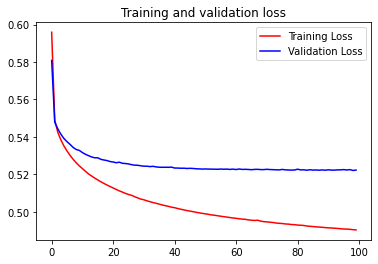

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [ ]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("arelu.csv")

# Sigmoid - LALR

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000, activation='sigmoid', input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000, activation='sigmoid'))
model.add(layers.Dense(4760, activation='relu'))

In [ ]:
from tensorflow.keras import backend as K
func_pen = K.function([model.layers[0].input], [model.layers[-2].output])
func_last = K.function([model.layers[0].input], [model.layers[-1].output])

In [ ]:
lrs = []
K1 = 0.
beta1 = 0.9
batch_size=200
from tqdm import tqdm

In [ ]:
def lr_schedule(epoch):
    global K1

    Kz = 0.
    Ka = 0.
    y_norm = 0.
    
    for i in range((len(x_train) - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
    	
        tmp_pen = np.array(func_pen([xb]))
        activ_pen = np.linalg.norm(tmp_pen)
        
        if activ_pen > Kz:
            Kz = activ_pen

        tmp_last = np.array(func_last([xb]))
        activ_last = np.linalg.norm(tmp_last)
        
        if activ_last > Ka:
            Ka = activ_last
        
        y_norms = np.linalg.norm(np.array(yb))
        if y_norms > y_norm:
            y_norm = y_norms


    print("The value of K_z is ",Kz, " The value of Ka is ",Ka, " Value of y is ",y_norm)
    K1 = (1/batch_size)*(Ka + y_norm)*Kz
    lr = 1 / K1
    lr = lr*0.3
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr


In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
optimizer = 'adam'
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

The value of K_z is  687.73627  The value of Ka is  290.97476  Value of y is  1052.7268806322327
Epoch 0 LR = 6.492717025767726e-05
Epoch 1/100
445/445 [==============================] - 62s 139ms/step - loss: 0.7460 - mse: 0.9918 - val_loss: 0.7475 - val_mse: 1.0024
The value of K_z is  585.4787  The value of Ka is  94.09681  Value of y is  1052.7268806322327
Epoch 1 LR = 8.936006908302536e-05
Epoch 2/100
445/445 [==============================] - 62s 139ms/step - loss: 0.7431 - mse: 0.9871 - val_loss: 0.7461 - val_mse: 1.0000
The value of K_z is  471.5679  The value of Ka is  107.53359  Value of y is  1052.7268806322327
Epoch 2 LR = 0.00010966082707474122
Epoch 3/100
445/445 [==============================] - 62s 140ms/step - loss: 0.7415 - mse: 0.9844 - val_loss: 0.7442 - val_mse: 0.9967
The value of K_z is  371.46375  The value of Ka is  125.69779  Value of y is  1052.7268806322327
Epoch 3 LR = 0.0001370670262582472
Epoch 4/100
445/445 [==============================] - 62s 139ms/s

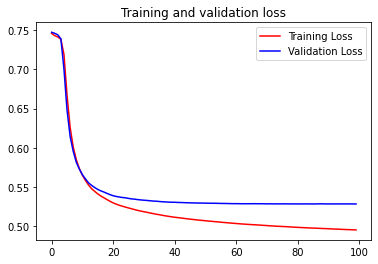

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [ ]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("Sigmoid.csv")

# Tanh - LALR

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000, activation='tanh', input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000, activation='tanh'))
model.add(layers.Dense(4760, activation='relu'))

In [ ]:
from tensorflow.keras import backend as K
func_pen = K.function([model.layers[0].input], [model.layers[-2].output])
func_last = K.function([model.layers[0].input], [model.layers[-1].output])

In [ ]:
lrs = []
K1 = 0.
beta1 = 0.9
batch_size=200
from tqdm import tqdm

In [ ]:
def lr_schedule(epoch):
    global K1

    Kz = 0.
    Ka = 0.
    y_norm = 0.
    
    for i in range((len(x_train) - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
    	
        tmp_pen = np.array(func_pen([xb]))
        activ_pen = np.linalg.norm(tmp_pen)
        
        if activ_pen > Kz:
            Kz = activ_pen

        tmp_last = np.array(func_last([xb]))
        activ_last = np.linalg.norm(tmp_last)
        
        if activ_last > Ka:
            Ka = activ_last
        
        y_norms = np.linalg.norm(np.array(yb))
        if y_norms > y_norm:
            y_norm = y_norms


    print("The value of K_z is ",Kz, " The value of Ka is ",Ka, " Value of y is ",y_norm)
    K1 = (1/batch_size)*(Ka + y_norm)*Kz
    lr = 1 / K1
    lr = lr*0.3
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr


In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
optimizer = 'adam'
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

The value of K_z is  448.9263  The value of Ka is  263.3161  Value of y is  1052.7268806322327
Epoch 0 LR = 0.00010155612650312227
Epoch 1/100
445/445 [==============================] - 33s 74ms/step - loss: 0.5842 - mse: 0.6196 - val_loss: 0.5614 - val_mse: 0.5850
The value of K_z is  523.5753  The value of Ka is  685.8551  Value of y is  1052.7268806322327
Epoch 1 LR = 6.591388515699199e-05
Epoch 2/100
445/445 [==============================] - 37s 82ms/step - loss: 0.5584 - mse: 0.5745 - val_loss: 0.5545 - val_mse: 0.5752
The value of K_z is  523.1439  The value of Ka is  697.98224  Value of y is  1052.7268806322327
Epoch 2 LR = 6.551127823985698e-05
Epoch 3/100
445/445 [==============================] - 36s 81ms/step - loss: 0.5546 - mse: 0.5683 - val_loss: 0.5528 - val_mse: 0.5724
The value of K_z is  528.28375  The value of Ka is  700.18317  Value of y is  1052.7268806322327
Epoch 3 LR = 6.479244460585413e-05
Epoch 4/100
445/445 [==============================] - 36s 82ms/step - 

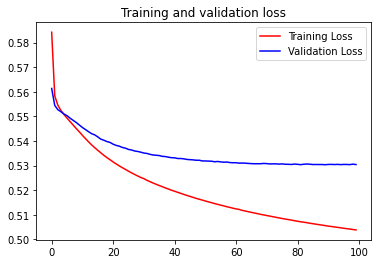

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [ ]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("Tanh.csv")

# Relu Constant

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000, activation='relu'))
model.add(layers.Dense(4760, activation='relu'))

In [ ]:
optimizer = tf.keras.optimizers.Adam(5e-7)
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test))

Epoch 1/100
445/445 [==============================] - 20s 44ms/step - loss: 0.7543 - mse: 0.9987 - val_loss: 0.7422 - val_mse: 0.9842
Epoch 2/100
445/445 [==============================] - 19s 43ms/step - loss: 0.7309 - mse: 0.9539 - val_loss: 0.7200 - val_mse: 0.9379
Epoch 3/100
445/445 [==============================] - 19s 43ms/step - loss: 0.7112 - mse: 0.9112 - val_loss: 0.7019 - val_mse: 0.8975
Epoch 4/100
445/445 [==============================] - 19s 43ms/step - loss: 0.6961 - mse: 0.8769 - val_loss: 0.6879 - val_mse: 0.8659
Epoch 5/100
445/445 [==============================] - 19s 43ms/step - loss: 0.6843 - mse: 0.8499 - val_loss: 0.6770 - val_mse: 0.8412
Epoch 6/100
445/445 [==============================] - 19s 43ms/step - loss: 0.6750 - mse: 0.8286 - val_loss: 0.6683 - val_mse: 0.8216
Epoch 7/100
445/445 [==============================] - 19s 43ms/step - loss: 0.6675 - mse: 0.8116 - val_loss: 0.6612 - val_mse: 0.8057
Epoch 8/100
445/445 [==============================] - 

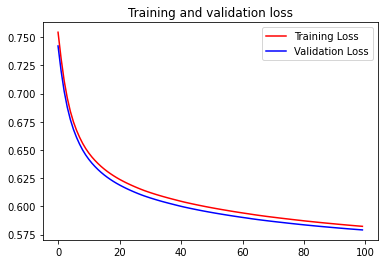

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("relu_cont.csv")

# Sigmoid Constant

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000, activation='sigmoid', input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000, activation='sigmoid'))
model.add(layers.Dense(4760, activation='relu'))

In [ ]:
optimizer = tf.keras.optimizers.Adam(5e-7)
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test))

Epoch 1/100
445/445 [==============================] - 20s 44ms/step - loss: 0.7688 - mse: 1.0339 - val_loss: 0.7520 - val_mse: 1.0106
Epoch 2/100
445/445 [==============================] - 19s 43ms/step - loss: 0.7486 - mse: 0.9963 - val_loss: 0.7507 - val_mse: 1.0079
Epoch 3/100
445/445 [==============================] - 19s 43ms/step - loss: 0.7472 - mse: 0.9935 - val_loss: 0.7488 - val_mse: 1.0038
Epoch 4/100
445/445 [==============================] - 19s 43ms/step - loss: 0.7453 - mse: 0.9894 - val_loss: 0.7463 - val_mse: 0.9985
Epoch 5/100
445/445 [==============================] - 19s 43ms/step - loss: 0.7428 - mse: 0.9840 - val_loss: 0.7434 - val_mse: 0.9924
Epoch 6/100
445/445 [==============================] - 19s 43ms/step - loss: 0.7400 - mse: 0.9779 - val_loss: 0.7405 - val_mse: 0.9861
Epoch 7/100
445/445 [==============================] - 19s 43ms/step - loss: 0.7371 - mse: 0.9718 - val_loss: 0.7377 - val_mse: 0.9802
Epoch 8/100
445/445 [==============================] - 

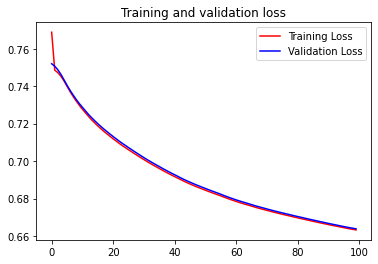

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("sigmoid_cont.csv")

# Tanh Const

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000, activation='tanh', input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000, activation='tanh'))
model.add(layers.Dense(4760, activation='relu'))

In [ ]:
optimizer = tf.keras.optimizers.Adam(5e-7)
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test))

Epoch 1/100
445/445 [==============================] - 19s 44ms/step - loss: 0.7615 - mse: 0.9991 - val_loss: 0.7250 - val_mse: 0.9255
Epoch 2/100
445/445 [==============================] - 19s 43ms/step - loss: 0.7120 - mse: 0.8880 - val_loss: 0.6889 - val_mse: 0.8454
Epoch 3/100
445/445 [==============================] - 19s 43ms/step - loss: 0.6855 - mse: 0.8282 - val_loss: 0.6683 - val_mse: 0.7993
Epoch 4/100
445/445 [==============================] - 19s 43ms/step - loss: 0.6689 - mse: 0.7906 - val_loss: 0.6543 - val_mse: 0.7679
Epoch 5/100
445/445 [==============================] - 19s 43ms/step - loss: 0.6570 - mse: 0.7638 - val_loss: 0.6439 - val_mse: 0.7448
Epoch 6/100
445/445 [==============================] - 19s 43ms/step - loss: 0.6478 - mse: 0.7436 - val_loss: 0.6358 - val_mse: 0.7272
Epoch 7/100
445/445 [==============================] - 19s 43ms/step - loss: 0.6405 - mse: 0.7279 - val_loss: 0.6293 - val_mse: 0.7135
Epoch 8/100
445/445 [==============================] - 

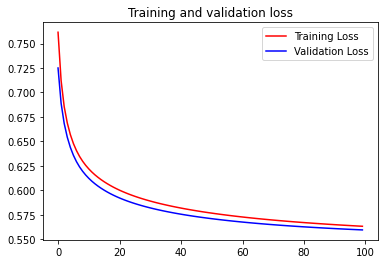

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("tanh_cont.csv")

# A-relu Const

In [ ]:
import tensorflow as tf
from keras.layers import Activation
import tensorflow.keras.backend as K
from tensorflow.keras import layers

In [ ]:
@tf.function
def ARELU(act):
  k = 0.54
  n = 1.30
  #print(act)
  x = act-act
  y = tf.where(act<=0,x,act)
  y = k * K.pow(y,n)
  t = tf.where(act<0,x,y)
  return t

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000,activation= ARELU,input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000,activation = ARELU))
model.add(layers.Dense(4760,activation = ARELU))

In [ ]:
optimizer = tf.keras.optimizers.Adam(5e-7)
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test))

Epoch 1/100
445/445 [==============================] - 21s 46ms/step - loss: 0.7501 - mse: 0.9963 - val_loss: 0.7529 - val_mse: 1.0092
Epoch 2/100
445/445 [==============================] - 20s 45ms/step - loss: 0.7488 - mse: 0.9932 - val_loss: 0.7503 - val_mse: 1.0026
Epoch 3/100
445/445 [==============================] - 20s 45ms/step - loss: 0.7417 - mse: 0.9757 - val_loss: 0.7357 - val_mse: 0.9672
Epoch 4/100
445/445 [==============================] - 20s 45ms/step - loss: 0.7233 - mse: 0.9325 - val_loss: 0.7174 - val_mse: 0.9240
Epoch 5/100
445/445 [==============================] - 20s 45ms/step - loss: 0.7090 - mse: 0.8988 - val_loss: 0.7053 - val_mse: 0.8953
Epoch 6/100
445/445 [==============================] - 20s 45ms/step - loss: 0.6983 - mse: 0.8738 - val_loss: 0.6952 - val_mse: 0.8718
Epoch 7/100
445/445 [==============================] - 20s 45ms/step - loss: 0.6892 - mse: 0.8527 - val_loss: 0.6865 - val_mse: 0.8520
Epoch 8/100
445/445 [==============================] - 

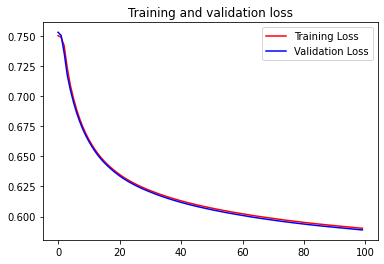

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("arelu_const.csv")

# Relu Decay

In [ ]:
def lr_decay(epoch):
  initial_lr=7e-5
  calculated_lr = initial_lr*np.exp(-0.01*epoch)
  if(epoch==0):
    print(initial_lr)
    return initial_lr
  elif(calculated_lr<1e-5):
    print('1e-5')
    return 1e-5
  else:
    print(calculated_lr)
    return calculated_lr

In [ ]:
lr_decayer = LearningRateScheduler(lr_decay)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000, activation='relu'))
model.add(layers.Dense(4760, activation='relu'))

In [ ]:
optimizer = 'adam'
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test),callbacks=[lr_decayer])

7e-05
Epoch 1/100
445/445 [==============================] - 34s 77ms/step - loss: 0.6239 - mse: 0.7279 - val_loss: 0.5916 - val_mse: 0.6712
6.930348836244176e-05
Epoch 2/100
445/445 [==============================] - 37s 84ms/step - loss: 0.5820 - mse: 0.6457 - val_loss: 0.5743 - val_mse: 0.6371
6.861390713147286e-05
Epoch 3/100
445/445 [==============================] - 36s 81ms/step - loss: 0.5680 - mse: 0.6181 - val_loss: 0.5646 - val_mse: 0.6176
6.793118734839557e-05
Epoch 4/100
445/445 [==============================] - 37s 83ms/step - loss: 0.5595 - mse: 0.6022 - val_loss: 0.5586 - val_mse: 0.6060
6.725526074066261e-05
Epoch 5/100
445/445 [==============================] - 37s 83ms/step - loss: 0.5533 - mse: 0.5903 - val_loss: 0.5540 - val_mse: 0.5966
6.658605971504998e-05
Epoch 6/100
445/445 [==============================] - 37s 83ms/step - loss: 0.5483 - mse: 0.5809 - val_loss: 0.5503 - val_mse: 0.5895
6.59235173508974e-05
Epoch 7/100
445/445 [==============================] 

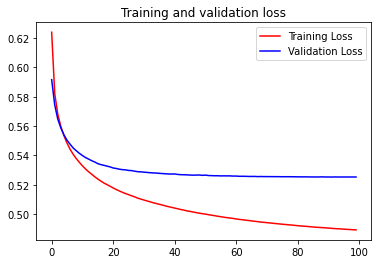

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("relu_decay.csv")

# Sigmoid Decay

In [5]:
def lr_decay(epoch):
  initial_lr=7e-5
  calculated_lr = initial_lr*np.exp(-0.01*epoch)
  if(epoch==0):
    print(initial_lr)
    return initial_lr
  elif(calculated_lr<1e-5):
    print('1e-5')
    return 1e-5
  else:
    print(calculated_lr)
    return calculated_lr

In [6]:
lr_decayer = LearningRateScheduler(lr_decay)

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000, activation='sigmoid', input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000, activation='sigmoid'))
model.add(layers.Dense(4760, activation='relu'))

In [8]:
optimizer = 'adam'
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [9]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test),callbacks=[lr_decayer])

7e-05
Epoch 1/100
445/445 [==============================] - 30s 68ms/step - loss: 0.7461 - mse: 0.9916 - val_loss: 0.7473 - val_mse: 1.0017
6.930348836244176e-05
Epoch 2/100
445/445 [==============================] - 31s 69ms/step - loss: 0.7430 - mse: 0.9866 - val_loss: 0.7458 - val_mse: 0.9994
6.861390713147286e-05
Epoch 3/100
445/445 [==============================] - 32s 72ms/step - loss: 0.7418 - mse: 0.9846 - val_loss: 0.7448 - val_mse: 0.9978
6.793118734839557e-05
Epoch 4/100
445/445 [==============================] - 32s 73ms/step - loss: 0.7407 - mse: 0.9829 - val_loss: 0.7437 - val_mse: 0.9958
6.725526074066261e-05
Epoch 5/100
445/445 [==============================] - 33s 74ms/step - loss: 0.7398 - mse: 0.9813 - val_loss: 0.7427 - val_mse: 0.9941
6.658605971504998e-05
Epoch 6/100
445/445 [==============================] - 34s 75ms/step - loss: 0.7385 - mse: 0.9789 - val_loss: 0.7411 - val_mse: 0.9913
6.59235173508974e-05
Epoch 7/100
445/445 [==============================] 

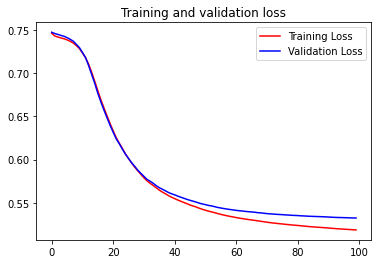

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [11]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("sigmoid_decay.csv")

# A-ReLU Decay

In [5]:
import tensorflow as tf
from keras.layers import Activation
import tensorflow.keras.backend as K
from tensorflow.keras import layers

In [6]:
@tf.function
def ARELU(act):
  k = 0.54
  n = 1.30
  #print(act)
  x = act-act
  y = tf.where(act<=0,x,act)
  y = k * K.pow(y,n)
  t = tf.where(act<0,x,y)
  return t

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000,activation= ARELU,input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000,activation = ARELU))
model.add(layers.Dense(4760,activation = ARELU))

In [8]:
def lr_decay(epoch):
  initial_lr=7e-5
  calculated_lr = initial_lr*np.exp(-0.01*epoch)
  if(epoch==0):
    print(initial_lr)
    return initial_lr
  elif(calculated_lr<1e-5):
    print('1e-5')
    return 1e-5
  else:
    print(calculated_lr)
    return calculated_lr

In [9]:
lr_decayer = LearningRateScheduler(lr_decay)

In [10]:
optimizer = 'adam'
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test),callbacks=[lr_decayer])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("arelu_decay.csv")

# Tanh Decay

In [12]:
import tensorflow as tf
from keras.layers import Activation
import tensorflow.keras.backend as K
from tensorflow.keras import layers

In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(9000,activation= 'tanh',input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9000,activation = 'tanh'))
model.add(layers.Dense(4760,activation = 'relu'))

In [14]:
def lr_decay(epoch):
  initial_lr=7e-5
  calculated_lr = initial_lr*np.exp(-0.01*epoch)
  if(epoch==0):
    print(initial_lr)
    return initial_lr
  elif(calculated_lr<1e-5):
    print('1e-5')
    return 1e-5
  else:
    print(calculated_lr)
    return calculated_lr

In [15]:
lr_decayer = LearningRateScheduler(lr_decay)

In [16]:
optimizer = 'adam'
model.compile(loss='mae', optimizer=optimizer, metrics=["mse"])

In [17]:
history=model.fit(x_train, y_train, epochs = 100, batch_size = 200,validation_data=(x_test,y_test),callbacks=[lr_decayer])

7e-05
Epoch 1/100
445/445 [==============================] - 36s 81ms/step - loss: 0.5896 - mse: 0.6301 - val_loss: 0.5620 - val_mse: 0.5878
6.930348836244176e-05
Epoch 2/100
445/445 [==============================] - 40s 90ms/step - loss: 0.5610 - mse: 0.5790 - val_loss: 0.5560 - val_mse: 0.5775
6.861390713147286e-05
Epoch 3/100
445/445 [==============================] - 40s 90ms/step - loss: 0.5559 - mse: 0.5704 - val_loss: 0.5538 - val_mse: 0.5738
6.793118734839557e-05
Epoch 4/100
445/445 [==============================] - 40s 89ms/step - loss: 0.5532 - mse: 0.5660 - val_loss: 0.5532 - val_mse: 0.5721
6.725526074066261e-05
Epoch 5/100
445/445 [==============================] - 40s 91ms/step - loss: 0.5514 - mse: 0.5630 - val_loss: 0.5515 - val_mse: 0.5698
6.658605971504998e-05
Epoch 6/100
445/445 [==============================] - 40s 89ms/step - loss: 0.5499 - mse: 0.5607 - val_loss: 0.5510 - val_mse: 0.5687
6.59235173508974e-05
Epoch 7/100
445/445 [==============================] 

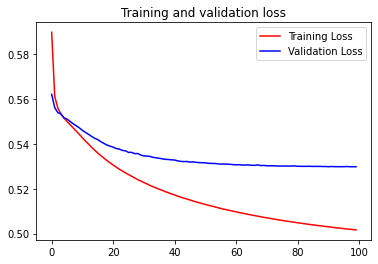

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [19]:
data1 = pd.DataFrame([history.history['loss'],history.history['val_loss']])
data1.to_csv("tanh_decay.csv")

In [45]:
arelu.iloc[1][:]

Unnamed: 0    1.000000
0             0.580835
1             0.547901
2             0.544326
3             0.541455
                ...   
95            0.522591
96            0.522383
97            0.522581
98            0.522138
99            0.522328
Name: 1, Length: 101, dtype: float64

# Visualization

In [28]:
cd My\ Drive/Parsimonious_data

/content/drive/My Drive/Parsimonious_data


In [38]:
arelu_const = pd.read_csv("arelu_const.csv")
relu_const = pd.read_csv("relu_const.csv")
sigmoid_const = pd.read_csv("sigmoid_const.csv")
tanh_const = pd.read_csv("tanh_const.csv")

arelu = pd.read_csv("arelu.csv")
relu = pd.read_csv("relu.csv")
sigmoid = pd.read_csv("sigmoid.csv")
tanh = pd.read_csv("tanh.csv")

arelu_decay = pd.read_csv("arelu_decay.csv")
relu_decay = pd.read_csv("relu_decay.csv")
sigmoid_decay = pd.read_csv("sigmoid_decay.csv")
tanh_decay = pd.read_csv("tanh_decay.csv")

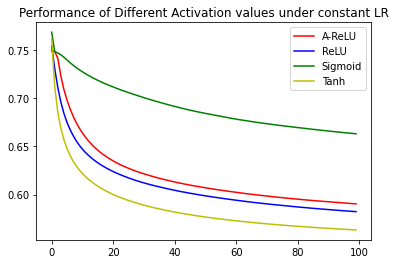

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
arelu_const_loss = arelu_const.iloc[0][1:]
relu_const_loss = relu_const.iloc[0][1:]
sigmoid_const_loss = sigmoid_const.iloc[0][1:]
tanh_const_loss = tanh_const.iloc[0][1:]

epochs = range(len(arelu_const_loss))

plt.plot(epochs, arelu_const_loss, 'r', label='A-ReLU')
plt.plot(epochs, relu_const_loss, 'b', label='ReLU')
plt.plot(epochs, sigmoid_const_loss, 'g', label='Sigmoid')
plt.plot(epochs, tanh_const_loss, 'y', label='Tanh')
plt.title('Performance of Different Activation values under constant LR')
plt.legend()
plt.show()


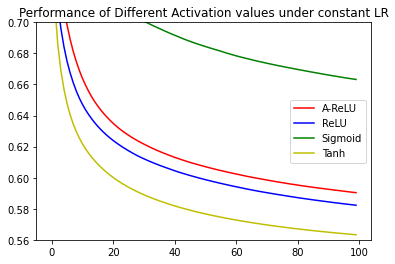

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
arelu_const_loss = arelu_const.iloc[0][1:]
relu_const_loss = relu_const.iloc[0][1:]
sigmoid_const_loss = sigmoid_const.iloc[0][1:]
tanh_const_loss = tanh_const.iloc[0][1:]

epochs = range(len(arelu_const_loss))

plt.plot(epochs, arelu_const_loss, 'r', label='A-ReLU')
plt.plot(epochs, relu_const_loss, 'b', label='ReLU')
plt.plot(epochs, sigmoid_const_loss, 'g', label='Sigmoid')
plt.plot(epochs, tanh_const_loss, 'y', label='Tanh')
plt.ylim(0.56,0.7)
plt.title('Performance of Different Activation values under constant LR')
plt.legend()
plt.show()


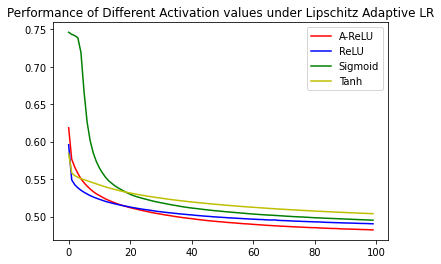

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
arelu_lalr_loss = arelu.iloc[0][1:]
relu_lalr_loss = relu.iloc[0][1:]
sigmoid_lalr_loss = sigmoid.iloc[0][1:]
tanh_lalr_loss = tanh.iloc[0][1:]

epochs = range(len(arelu_lalr_loss))

plt.plot(epochs, relu_lalr_loss, 'r', label='A-ReLU')
plt.plot(epochs, arelu_lalr_loss, 'b', label='ReLU')
plt.plot(epochs, sigmoid_lalr_loss, 'g', label='Sigmoid')
plt.plot(epochs, tanh_lalr_loss, 'y', label='Tanh')
plt.title('Performance of Different Activation values under Lipschitz Adaptive LR')
plt.legend()
plt.show()


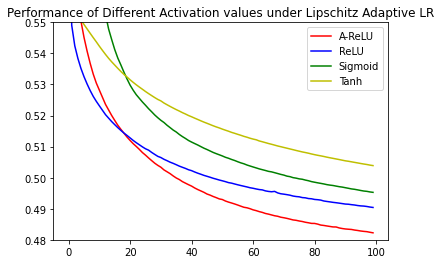

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
arelu_lalr_loss = arelu.iloc[0][1:]
relu_lalr_loss = relu.iloc[0][1:]
sigmoid_lalr_loss = sigmoid.iloc[0][1:]
tanh_lalr_loss = tanh.iloc[0][1:]

epochs = range(len(arelu_lalr_loss))

plt.plot(epochs, relu_lalr_loss, 'r', label='A-ReLU')
plt.plot(epochs, arelu_lalr_loss, 'b', label='ReLU')
plt.plot(epochs, sigmoid_lalr_loss, 'g', label='Sigmoid')
plt.plot(epochs, tanh_lalr_loss, 'y', label='Tanh')
plt.ylim(0.48,0.55)
plt.title('Performance of Different Activation values under Lipschitz Adaptive LR')
plt.legend()
plt.show()


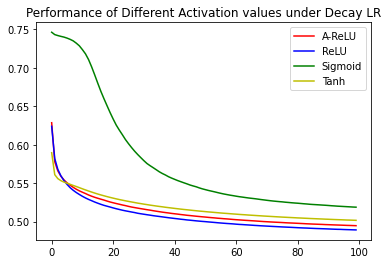

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
arelu_decay_loss = arelu_decay.iloc[0][1:]
relu_decay_loss = relu_decay.iloc[0][1:]
sigmoid_decay_loss = sigmoid_decay.iloc[0][1:]
tanh_decay_loss = tanh_decay.iloc[0][1:]

epochs = range(len(arelu_decay_loss))

plt.plot(epochs, arelu_decay_loss, 'r', label='A-ReLU')
plt.plot(epochs, relu_decay_loss, 'b', label='ReLU')
plt.plot(epochs, sigmoid_decay_loss, 'g', label='Sigmoid')
plt.plot(epochs, tanh_decay_loss, 'y', label='Tanh')
plt.title('Performance of Different Activation values under Decay LR')
plt.legend()
plt.show()


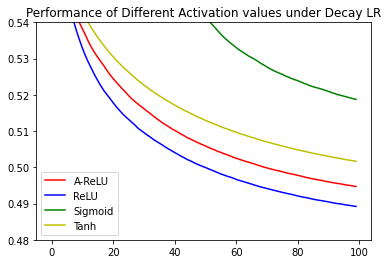

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
arelu_decay_loss = arelu_decay.iloc[0][1:]
relu_decay_loss = relu_decay.iloc[0][1:]
sigmoid_decay_loss = sigmoid_decay.iloc[0][1:]
tanh_decay_loss = tanh_decay.iloc[0][1:]

epochs = range(len(arelu_decay_loss))

plt.plot(epochs, arelu_decay_loss, 'r', label='A-ReLU')
plt.plot(epochs, relu_decay_loss, 'b', label='ReLU')
plt.plot(epochs, sigmoid_decay_loss, 'g', label='Sigmoid')
plt.plot(epochs, tanh_decay_loss, 'y', label='Tanh')
plt.ylim(0.48,0.54)
plt.title('Performance of Different Activation values under Decay LR')
plt.legend()
plt.show()
